This is where I sort out technical things about the primary beam.

- How to FFT a circle
- Compare David's fitted beam to James fitted beam
- Decide on whether I should use ENZ (and then convolve) or if I just multiply things in the aperture plane and then FT

# FFT'ing a circle

In [16]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import constants as const

Always do an odd number of pixels or else I can't get the phases to be zero

In [6]:
e_a = np.zeros((99, 99))
xy = np.meshgrid(np.mgrid[-49:49:99j], np.mgrid[-49:49:99j])

In [3]:
xy[0].shape

(99, 99)

In [9]:
#e_a[np.sqrt(xy[0] ** 2 + xy[1] ** 2) <= 5] = 1
rr, cc = draw.disk((49, 49), 5, shape=e_a.shape)
e_a[rr, cc] = 1

In [ ]:
ph = 

In [10]:
from skimage import draw

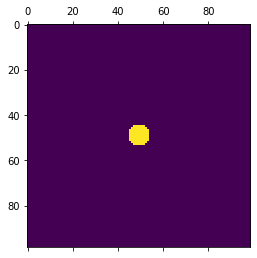

In [11]:
plt.matshow(e_a)

In [12]:
a = fft.fft2(e_a)

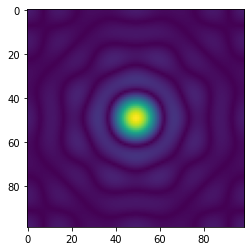

In [13]:
plt.imshow(fft.fftshift(np.abs(a)))

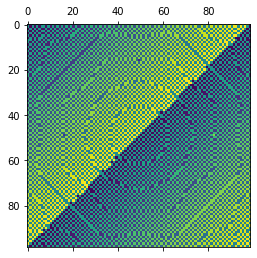

In [14]:
plt.matshow(fft.fftshift(np.angle(a)))

In [51]:
np.abs(a.imag).max()

12.986220222012351

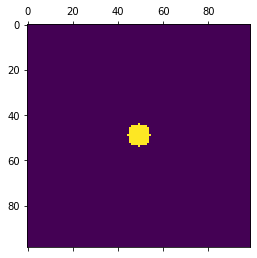

In [3]:
e_a2 = np.zeros((99, 99))
xy2 = np.meshgrid(np.mgrid[-49:49:99j], np.mgrid[-49:49:99j])
e_a2[np.sqrt(xy2[0] ** 2 + xy2[1] ** 2) <= 5] = 1
plt.matshow(e_a2)

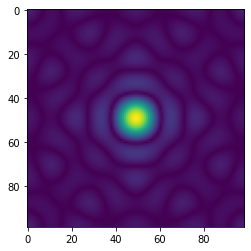

In [5]:
plt.imshow(np.abs(fft.fftshift(fft.fft2(e_a2))))

In [63]:
from scipy.special import jv
DIAM = 5
c1=1.091
c4=0.957
c6=-0.139
c11=0.445

def vBz(theta, phi, m, n, lambd):
    r = np.outer(DIAM / (2 * lambd), theta)
    if m>= 0:
        return jv(n+1, 2 * np.pi * r) * np.cos(m*phi) / (np.pi * r)
    else:
        return jv(n+1, 2 * np.pi * r) * np.sin(-m*phi) / (np.pi * r)

In [64]:
#freq_arr = (np.arange(8000) * 162.5e3) + 0.7e9
#lambd_arr = 2.99792e8/freq_arr
lambda_arr = np.array([2.99792e8/2e9])
theta_deg = (np.arange(100) * 0.1)
theta_arr = theta_deg / 57.2958

In [65]:
vbz_beam = (c1 * vBz(theta_arr, 0, 0, 0, lambd_arr[-1]) +
             c4 * vBz(theta_arr, 0, 0, 2, lambd_arr[-1]) +
             c6 * vBz(theta_arr, 0, 2, 2, lambd_arr[-1]) +
             c11 * vBz(theta_arr, 0, 2, 4, lambd_arr[-1]))

/tmp/ipykernel_1877464/1548487688.py:11: RuntimeWarning: invalid value encountered in true_divide
  return jv(n+1, 2 * np.pi * r) * np.cos(m*phi) / (np.pi * r)


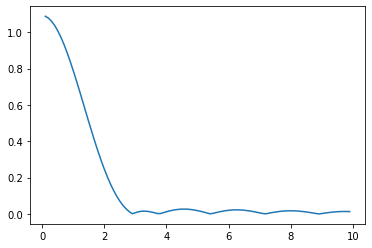

In [26]:
plt.plot(np.abs(vbz_beam[0]))

# James's fits

In [67]:
# zero pad and FFT
def to_beam(illum, xy, f, pad_factor):
    # pad_factor gives how many over-sampled we want one resolution element to be
    pad_size = (illum.shape[0] // 2) * (pad_factor - 1)
    illum_padded = np.pad(illum, pad_size)
    print('padded size is: ', illum_padded.shape[0])
    beam = fft.fftshift(fft.fft2(illum_padded)) / illum.size # normalize to peak of 1
    dl = (((xy[0][0][1] - xy[0][0][0]) * f)/(2 * np.pi * const.c)).to(u.dimensionless_unscaled)
    l = fft.fftfreq(illum_padded.shape[0], d=dl)
    lm = fft.fftshift(np.meshgrid(l, l)) * u.radian
    return lm, beam

In [68]:
coeffs = np.array([0.41014, 0.09540, -0.27752, 0.17076, -0.05474, 0.00988, -0.00095])
GRID_SIZE = 50 # for the dish part
DIAM = 5

ea_grid_m = np.meshgrid(np.linspace(-DIAM, DIAM, num=GRID_SIZE + 1), np.linspace(-DIAM, DIAM, num=GRID_SIZE + 1))
ea_grid = np.sum(np.power(np.sqrt(ea_grid_m[0][:-1, :-1]**2 + ea_grid_m[1][:-1, :-1]**2), np.arange(1, len(coeffs) + 1)[:,np.newaxis, np.newaxis]), axis=0)
aper_mask = ( np.sqrt(ea_grid_m[0][:-1,:-1]**2 + ea_grid_m[1][:-1, :-1]**2) < (5))
ea_grid[~aper_mask] = 0

# stick units in there
DIAM *= u.m
ea_grid_m *= u.m

lm0, beam0 = to_beam(ea_grid, ea_grid_m, 2 * u.GHz , 250)

padded size is:  12500


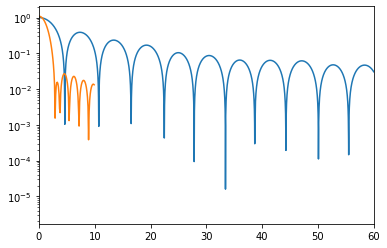

In [58]:
plt.plot((lm0[1][beam0.shape[0]//2]).to(u.deg), np.abs(beam0[:, beam0.shape[0]//2])/np.abs(beam0[:, beam0.shape[0]//2]).max())
plt.plot(theta_deg, np.abs(vbz_beam[0]))
plt.xlim([0,60])
plt.yscale('log')

In [35]:
lm0.shape

(2, 12500, 12500)

In [36]:
beam0.shape

(12500, 12500)

In [38]:
(lm0[1][beam0.shape[0]//2]).to(u.deg)

<Quantity [-199.86163867, -199.8296608 , -199.79768294, ...,  199.76570508,
            199.79768294,  199.8296608 ] deg>

In [55]:
np.arccos((lm0[1][beam0.shape[0]//2])/u.rad)[beam0.shape[0]//2:]

/home/yuping/.local/share/virtualenvs/frank-1tGSZLq3/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Quantity [1.57079633, 1.57023821, 1.56968009, ...,        nan,        nan,
                  nan] rad>

In [42]:
lm0[1][beam0.shape[0]//2]/u.rad

<Quantity [-3.48824364, -3.48768552, -3.48712741, ...,  3.48656929,
            3.48712741,  3.48768552]>

/home/yuping/.local/share/virtualenvs/frank-1tGSZLq3/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in arcsin
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(0.001, 1)

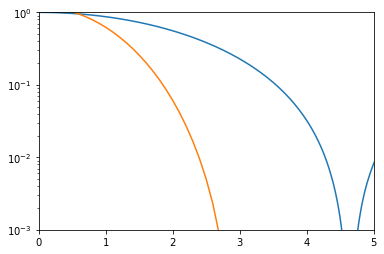

In [72]:
plt.plot(np.arcsin((lm0[1][beam0.shape[0]//2])/u.rad)[beam0.shape[0]//2:]*57.2958,
         (np.abs(beam0[beam0.shape[0]//2:, beam0.shape[0]//2])/np.abs(beam0[ beam0.shape[0]//2:, beam0.shape[0]//2]).max())**2)
plt.plot(theta_deg, np.abs(vbz_beam[0])**2)
plt.xlim([0,5])
plt.yscale('log')
plt.ylim([1e-3, 1])